In [69]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

torch.manual_seed(42)

%matplotlib inline

In [70]:
BLOCK_SIZE = 3
N_EMBED = 10
N_HIDDEN = 200
N_EPOCHS = 200000
BATCH_SIZE = 32
g = torch.Generator().manual_seed(2147483647)

In [71]:
def createWordsMapping(filename = 'names.txt'):
  words = open(filename, 'r').read().splitlines()
  chars = sorted(list(set(''.join(words))))
  stoi = {s:i+1 for i,s in enumerate(chars)}
  stoi['.'] = 0
  itos = {i:s for s,i in stoi.items()}
  n_vocab = len(stoi)
  return words, stoi, itos, n_vocab

def buildDataset(words, block_size):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X,Y

def buildDatasets(words, block_size):
  random.seed(42)
  random.shuffle(words)
  
  n1 = int(0.8 * len(words))
  n2 = int(0.9 * len(words))
  
  Xtr, Ytr = buildDataset(words[:n1], block_size)
  Xdev, Ydev = buildDataset(words[n1:n2], block_size)
  Xte, Yte = buildDataset(words[n2:], block_size)

  return Xtr, Ytr, Xdev, Ydev, Xte, Yte

In [72]:
words, stoi, itos, n_vocab = createWordsMapping()
Xtr, Ytr, Xdev, Ydev, Xte, Yte = buildDatasets(words, BLOCK_SIZE)
n_embed, n_hidden, block_size, n_epochs, batch_size = N_EMBED, N_HIDDEN, BLOCK_SIZE, N_EPOCHS, BATCH_SIZE
X, Y = Xtr, Ytr

In [73]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g)/ fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdims=True)
      xvar = x.var(0, keepdims=True, unbiased=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum *xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []
  
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]
  
class Faltten:

  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  def parameters(self):
    return []
  
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [74]:
def initializeWeights(n_vocab, block_size, n_embed, n_hidden):
    
  model = Sequential([
    Embedding(n_vocab, n_embed),
    Faltten(),
    Linear(n_embed*block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_vocab)
  ])

  with torch.no_grad():
    model.layers[-1].weight *= 0.1 # Make last layer less confident
  
  parameters = model.parameters()
  for p in parameters:
    p.requires_grad = True

  print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')
  return model

model = initializeWeights(n_vocab, BLOCK_SIZE, N_EMBED, N_HIDDEN)

Total Parameters: 12097


      0/ 200000: 3.2989
  10000/ 200000: 2.5262
  20000/ 200000: 2.3322
  30000/ 200000: 2.4588
  40000/ 200000: 2.3534
  50000/ 200000: 2.2488
  60000/ 200000: 2.2621
  70000/ 200000: 2.1031
  80000/ 200000: 2.4951
  90000/ 200000: 2.1754
 100000/ 200000: 2.5588
 110000/ 200000: 1.9678
 120000/ 200000: 2.2628
 130000/ 200000: 2.3522
 140000/ 200000: 2.1364
 150000/ 200000: 2.5152
 160000/ 200000: 2.5151
 170000/ 200000: 2.1397
 180000/ 200000: 2.2064
 190000/ 200000: 1.9896


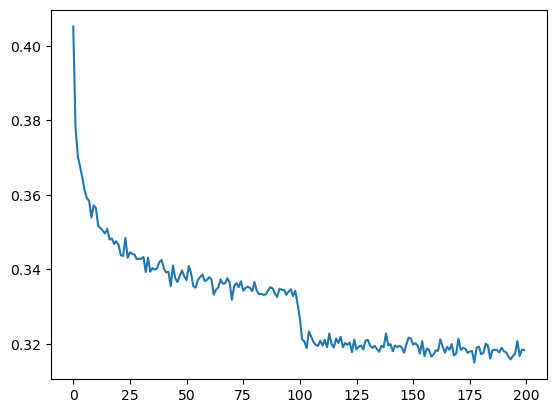

In [75]:
def trainModel(X, Y, model, n_epochs, batch_size):
  lossi = []
  ud = []
  parameters = model.parameters()

  for epoch in range(n_epochs):

    # Minibatch Construct
    ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X[ix], Y[ix] # batch X, Y 

    # Forward Pass
    logits = model(X_batch)
    loss = F.cross_entropy(logits, Y_batch)

    # Backward Pass
    for p in parameters:
      p.grad = None
    loss.backward()

    # Update Parameters
    lr = 0.1 if epoch < 100000 else 0.01 # stop learning rate decay
    for p in parameters:
      p.data += -lr * p.grad
    
    # Track Stats
    lossi.append(loss.log10().item())
    with torch.no_grad():
      ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])
    if epoch % 10000 == 0:
      print(f'{epoch:7d}/{n_epochs:7d}: {loss.item():.4f}')
  
  plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
  return lossi, ud, parameters

lossi, ud, parameters = trainModel(Xtr, Ytr, model, N_EPOCHS, BATCH_SIZE)

In [76]:
@torch.no_grad()
def loss(X, Y, model):
  for layer in model.layers:
    layer.training = False
  logits = model(X)
  loss = F.cross_entropy(logits, Y)
  return loss

In [77]:
print(f'Train Loss: {loss(Xtr, Ytr, model)}')
print(f'Val Loss: {loss(Xdev, Ydev, model)}')

Train Loss: 2.062875986099243
Val Loss: 2.106158494949341


In [78]:
def generateExample(model, block_size, itos):
  out = []
  context = [0] * block_size
  while True:
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  return ''.join(itos[i] for i in out)

def generateExamples(model, block_size, itos, numExamples = 20):
  for layer in model.layers:
    layer.training = False
  examples = []
  for _ in range(numExamples):
    example = generateExample(model, block_size, itos)
    examples.append(example)
  return examples

In [79]:
examples = generateExamples(model, BLOCK_SIZE, itos)
print(f'Generated Examples: {examples}')

Generated Examples: ['adrabethi.', 'abdejy.', 'mari.', 'rosa.', 'amilina.', 'tal.', 'jenie.', 'treyving.', 'brhyre.', 'aly.', 'salilia.', 'joey.', 'stesha.', 'centwardielle.', 'onitte.', 'ashi.', 'kansly.', 'xaydon.', 'beea.', 'broralee.']
